## Watson Call Center Analytics Lab

This document provides guidance and background for a hands-on Python + IBM Watson focusing on running Watson APIs on audio files (which represent Call Center audio recordings) to extract useful information and create call center analytics dashboards. 


### Why is this useful?
Enterprises spend more than $1 trillion on 250 billion customer service calls each year.  By using multiple IBM Watson "signal services" to extract signal from raw audio data; perform data analytics, clustering, unsupervised and machine learning, and visualizations, technical teams can use data understand patterns in call centers. KPI and ROI positive.

### What is the process? And what Watson services are used?
- Step 1 - Speech to Text (STT) – Converts Raw Audio to Transcripts; 
- Step 2 - Natural Language Understanding (NLU) - extracts features concepts, entities, keywords, categories/topics, sentiment and emotion; 
- Step 3 - Tone Analyzer (Tone) – uses linguistic analysis to detect emotional and language tones in written text; 
- Step 4 - Call Center Analytics – analyzes and visualizes the data signal to allow for interpretation of data and in cases, actionable insights; 


### Beginner Audience & Focus on Basics
- This is a beginner lab intended to educate on the fundamentals of getting from data to insights with IBM Watson and open source tools 
- Audience may include IT and operations teams curious about enriching unstructured data – the lab is NOT intended for sophisticated call center technologists 
- Lab/code does NOT purport to compete with expensive and sophisticated solutions already in market 
- The lab and code cover the basics – to educate on the fundamental plumbing and steps, to provide base for instrumentation 

### Success Metrics
If successful – the lab participants or notebook users will
1.	Gain experience in using an IPython / Jupyter notebook
https://ipython.org/notebook.html
2.	Connect to four Watson Developer Cloud ‘signal service’ APIs 
https://www.ibm.com/watson/developer/ 
3.	Connect to IBM Cloud Object storage for data read and write 
https://www.ibm.com/cloud/object-storage 




## Step 1 – Speech to Text (STT)
## Install Python Dependencies

Python’s standard library is very extensive, offering a wide range of facilities.  It contains built-in modules like JSON a lightweight data interchange format.  https://docs.python.org/2/library/index.html and https://docs.python.org/2/library/json.html

IBM Watson has a Python client library to quickly get started with the various Watson APIs services.
https://pypi.python.org/pypi/watson-developer-cloud

Using Python with IBM COS: Python support is provided through the Boto 3 library. The boto3 library provides complete access and can source credentials. The IBM COS endpoint must be specified when creating a service resource or low-level client as shown in documentation
https://ibm-public-cos.github.io/crs-docs/python


In [2]:
#!pip install watson_developer_cloud
!pip install ibm_watson
!pip install --upgrade --force-reinstall wordcloud
!pip install --user --upgrade pixiedust
!pip install pyspark

  Using cached https://files.pythonhosted.org/packages/ae/af/849edf14d573eba9c8082db898ff0d090428d9485371cc4fe21a66717ad2/wordcloud-1.5.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/19/b9/bda9781f0a74b90ebd2e046fde1196182900bd4a8e1ea503d3ffebc50e7c/numpy-1.17.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: numpy 1.17.0
    Uninstalling numpy-1.17.0:
      Successfully uninstalled numpy-1.17.0
  Found existing installation: Pillow 6.1.0
    Uninstalling Pillow-6.1.0:
      Successfully uninstalled Pillow-6.1.0
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
Requirement already up-to-date: pixiedus

In [3]:
#imports.... Run this each time after restarting the Kernel

#import watson_developer_cloud as watson

import json
from botocore.client import Config
import ibm_boto3
import requests
from urllib.request import urlopen 

import io
from os.path import join, dirname


## Accessig Same Audio Files
For purposes of this lab, we will use a number of sample audio files which are hosted on github. Download these files from github and then upload them to your Watson Studio project. Lastly, access these files in code by using the **Insert to code** functionality.

- Download the zip file from https://github.com/joe4k/watson-for-call-center-2019/blob/master/resource_files.tar.gz
- Unzip the downloaded file to get the different sample audio files (you should have 6 .ogg files)
- Upload the files to your Watson Studio project by clicking the **Find and Add Data** icon (top right) and either dropping the files directly or browsing to select and upload the files.

After upload the files to your Watson Studio project (they get uploaded to the Cloud Object Storage instance associated with your Watson Studio project), click in the next cell and then select the file **sample1-addresschange-positive.ogg** file and click **Insert to code** and then **Insert Credentials**. The credentials should look like the following:
```
credentials_1 = {
    'IAM_SERVICE_ID': '#####',
    'IBM_API_KEY_ID': '#####',
    'ENDPOINT': '####',
    'IBM_AUTH_ENDPOINT': '####',
    'BUCKET': '####',
    'FILE': '####'
}
```

In [4]:
# The code was removed by Watson Studio for sharing.

## Setup COS Client
In the next cell, define the Cloud Object Storage python client to access the files in your COS instance.

In [5]:
cos_client = ibm_boto3.client(service_name='s3',
                              ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                              ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                              config=Config(signature_version='oauth'),
                              endpoint_url=credentials_1['ENDPOINT'])



## Setup Credentials for Watson Speech to Text
Get the service credentials from your Watson Speech to Text instance by navigating to your IBM Cloud account, identifying the STT service instance you created and clicking on the Service Credentials in the left navigation column. Thecredentials will look as follows:

```
credentials_stt = {
  "apikey": "#####",
  "iam_apikey_description": "#############",
  "iam_apikey_name": "##########",
  "iam_role_crn": "#########",
  "iam_serviceid_crn": "#####",
  "url": "#######"
}
```

In [6]:
# The code was removed by Watson Studio for sharing.

### Functions to Prcess Audio Files
Next, define a set of functions to process audio files.

Following cell has two methods:
 - `get_transcript()` calls speech to text enpoint and generates a text transcript for you for a sample audio file.
 - `analyze_sample()` gets the sample object from cloud storage, calls get_transcript to fetch the tranccript, and saves your transcript in cloud storage as `<file_name>_text.json`.
 
OGG, WAV FLAC, L16, MP3, MPEG formats are options for the IBM Watson STT service.  For the lab we use OGG samples. 


In [7]:
from ibm_watson import SpeechToTextV1

speech_to_text = SpeechToTextV1(
    iam_apikey=credentials_stt['apikey'],
    url=credentials_stt['url']
)


# OGG, WAV FLAC, L16, MP3, MPEG formats are options for the STT service 
# with Narrowband (generaly telco) and Broadband (e.g. higher quality USB mic) audio.  
# For the LAB – OGG format was used for sample files in lab. Of other audio formats e.g. WAV - remember to change 'OGG' content_type='audio/ogg' in code below if you do.

#get transcript Very basic one
def get_transcript(audio):
    transcript = json.dumps(speech_to_text.recognize(audio=audio, content_type='audio/ogg', timestamps=True,
        word_confidence=True).get_result(), indent=2)
    return transcript

def download_file(path, filename):
    url = path + filename
    print(url)
    r = requests.get(url, stream=True)
    return r.content

def analyze_sample(sample):
    #streaming_body = client_global.get_object(Bucket = credentials_audio_samples['BUCKET'], Key=sample)['Body'] #http
    streaming_body = cos_client.get_object(Bucket = credentials_1['BUCKET'], Key=sample)['Body'] #http
    audio = streaming_body.read()
    text = get_transcript(audio)
    cos_client.put_object(Bucket = credentials_1['BUCKET'], Key = sample.split('.')[0] + '_text.json', Body = text)
    return text

def visualize(transcript):
    for result in json.loads(transcript)['results']:
        print(result['alternatives'][0]['transcript'], result['alternatives'][0]['confidence'])   

file_list provides list of audio file in an array, each OGG file produces its own transcript.

- Samples 1,2,3,4,5 are short - about 2 minutes 
- Samples 6 and 7 are about 7 minutes (the STT SERVICE WILL NEED TIME TO PROCESS)


In [8]:
file_list = ['sample1-addresschange-positive.ogg',
             'sample2-address-negative.ogg',
             'sample3-shirt-return-weather-chitchat.ogg',
             'sample4-angryblender-sportschitchat-recovery.ogg',
             'sample5-calibration-toneandcontext.ogg',
             'jfk_1961_0525_speech_to_put_man_on_moon.ogg',
             'May 1 1969 Fred Rogers testifies before the Senate Subcommittee on Communications.ogg']

file_list = ['sample1-addresschange-positive.ogg']



In [9]:
# TRANSCRIBE – this is where STT receives the OGG files provided and returns text to TRANSCRIPT
# this is a test of ONE transcription in the list - place '0' - may take a minute
transcript = analyze_sample(file_list[0])
visualize(transcript)

good morning  0.97
can you give me some help I'd like to change my address please  0.98
my name is Ryan Smith  0.99
I am from Sacramento California  0.95
that's right  0.96
my phone number is five five five one two one two  0.92
yes that's me  0.97
my old address is number one two three oak street  0.97
my new address is five six seven pine street  0.93
yes and the zip is nine eight zero two one zero  0.94
yep that's right  0.81
no the phone number stays the same  0.88
that's right I would like to keep all the options of said no other changes the only thing that I want to change is the address  0.93
yes that's right  0.97
yep  0.55
very good yeah thank you so much for help  0.88
thanks have a good day bye bye  0.91


## STT Transcription for ALL Files
Run STT on all audio files to generate *json file to capture the transcripts

In [10]:
for filename in file_list:
    print('Processing file: ', filename)
    transcript = analyze_sample(filename)
    visualize(transcript)

Processing file:  sample1-addresschange-positive.ogg
good morning  0.97
can you give me some help I'd like to change my address please  0.98
my name is Ryan Smith  0.99
I am from Sacramento California  0.95
that's right  0.96
my phone number is five five five one two one two  0.92
yes that's me  0.97
my old address is number one two three oak street  0.97
my new address is five six seven pine street  0.93
yes and the zip is nine eight zero two one zero  0.94
yep that's right  0.81
no the phone number stays the same  0.88
that's right I would like to keep all the options of said no other changes the only thing that I want to change is the address  0.93
yes that's right  0.97
yep  0.55
very good yeah thank you so much for help  0.88
thanks have a good day bye bye  0.91


In [11]:
#

# Step 2 - NLU
In this step, we run NLU on the transcript extracted in the previous step.

First, create Natural Language Understanding service (IBM Cloud Catalog) and add the service credentials in the next cell. The credentials will look as follows:
```
credentials_nlu = {
  "apikey": "#######,
  "iam_apikey_description": "###########",
  "iam_apikey_name": "###########",
  "iam_role_crn": "############",
  "iam_serviceid_crn": "#############",
  "url": "###############"
}
```


In [12]:
# The code was removed by Watson Studio for sharing.

The next cell defines some functions to call NLU. Add the missing code to define the NLU python object by calling the Watson Python SDK.

In [13]:

## START ADDING CODE

from ibm_watson import NaturalLanguageUnderstandingV1

from ibm_watson.natural_language_understanding_v1 \
    import Features, EntitiesOptions, KeywordsOptions

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    iam_apikey=credentials_nlu['apikey'],
    url=credentials_nlu['url'])

#### END ADDING CODE


chunk_size=25 # This CHUNK size is used to disaggregate a transcript 
#e.g. in this case a 290 word transcript would have 10 chunks - 9 with 30 words and 1 with 20 words - approximates 'time domain' for this lab

def chunk_transcript_nlu(transcript, chunk_size):
    transcript = transcript.split(' ')
    return [ transcript[i:i+chunk_size] for i in range(0, len(transcript), chunk_size) ] # chunking data

def process_text_nlu(text):
    transcript=''
    for sentence in json.loads(text)['results']:
        transcript = transcript + sentence['alternatives'][0]['transcript'] # concatenate sentences
    #transcript = chunk_transcript(transcript, chunk_size) # chunk the transcript
    return [transcript]


def analyze_transcript_nlu(features, file_name):
    streaming_body = cos_client.get_object(Bucket = credentials_1['BUCKET'], Key=file_name.split('.')[0]+'_text.json')['Body']
    transcript=streaming_body.read().decode("utf-8")
    nlu_analysis={}
    for chunk in process_text_nlu(transcript):
        #chunk = ' '.join(chunk)
        nlu_analysis[chunk] = natural_language_understanding.analyze(features, chunk, return_analyzed_text=True).get_result()
    res=cos_client.put_object(Bucket = credentials_1['BUCKET'], Key=file_name.split('.')[0]+'_NLU.json', Body= json.dumps(nlu_analysis))
    return nlu_analysis

def post_analysis_nlu(result):
    for chunk in result.keys():
        categories = result[chunk]['categories']
        print('\nchunk: ', chunk)
        for category in categories:
            print('label: ', category['label'], ', score: ', category['score']) #add table instead of prints

In [14]:
features = {"concepts":{},"entities":{},"keywords":{},"categories":{},"emotion":{},"sentiment":{},"semantic_roles":{} }
result = analyze_transcript_nlu(features, file_list[0])

post_analysis_nlu(result)


chunk:  good morning can you give me some help I'd like to change my address please my name is Ryan Smith I am from Sacramento California that's right my phone number is five five five one two one two yes that's me my old address is number one two three oak street my new address is five six seven pine street yes and the zip is nine eight zero two one zero yep that's right no the phone number stays the same that's right I would like to keep all the options of said no other changes the only thing that I want to change is the address yes that's right yep very good yeah thank you so much for help thanks have a good day bye bye 
label:  /business and industrial/business operations/business plans , score:  0.601661
label:  /sports/go kart , score:  0.57272
label:  /law, govt and politics , score:  0.568343


In the next cell, add code to repeat for the other files in the list

In [15]:
## START ADDING CODE
for f in file_list:
    print("processing file: ", f)
    results = analyze_transcript_nlu(features, f)

## END ADDING CODE

processing file:  sample1-addresschange-positive.ogg


# Step 3 - Tone Analyzer

https://www.ibm.com/watson/developercloud/tone-analyzer.html https://www.ibm.com/watson/developercloud/tone-analyzer/api/v3/

Tone Analyzer service uses linguistic analysis to detect emotional and language tones in written text.

To create a TONE endpoint - https://console.bluemix.net/developer/watson/dashboard LITE Plan for Tone is free

Tone Analyzer Signals
A comma-separated list of tones for which the service is to return its analysis of the input. The indicated tones apply both to the full document and to individual sentences of the document. You can specify one or more of the following values: emotion language social

2016-05-19: The service can return results for the following tone IDs of the different categories: For the emotion category: anger, disgust, fear, joy, sadness For the language category: analytical, confident, tentative For the social category: openness_big5, conscientiousness_big5, extraversion_big5, agreeableness_big5, emotional_range_big5 The service returns scores for all tones of a category, regardless of their values.

2017-09-21: The service can return results for the following tone IDs: anger, fear, joy, sadness, analytical, confident, and tentative. The service returns results only for tones whose scores meet a minimum threshold of 0.5.

If Tone Chat Score is used - these are the signals produced sad frustrated satisfied excited polite impolite sympathetic

In the next cell, add credentials for Tone Analyzer service.
```
{
  "apikey": "#########",
  "iam_apikey_description": "############",
  "iam_apikey_name": "#############",
  "iam_role_crn": "##################",
  "iam_serviceid_crn": "###############",
  "url": "#############"
}
```


In [17]:
# The code was removed by Watson Studio for sharing.

In [20]:
########
## START ADDING CODE

from ibm_watson import ToneAnalyzerV3

tone_analyzer = ToneAnalyzerV3(
    version='2017-09-21',
    iam_apikey=credentials_ta['apikey'],
    url=credentials_ta['url']
)

#### END ADDING CODE


chunk_size=25

def chunk_transcript_ta(transcript, chunk_size):
    transcript = transcript.split(' ')
    return [ transcript[i:i+chunk_size] for i in range(0, len(transcript), chunk_size) ] # chunking data
    

def process_text_ta(text):
    transcript=''
    for sentence in json.loads(text)['results']:
        transcript = transcript + sentence['alternatives'][0]['transcript'] # concatenate sentences
    transcript = chunk_transcript_ta(transcript, chunk_size) # chunk the transcript
    return transcript


def analyze_transcript_ta(file_name):
    transcript = cos_client.get_object(Bucket = credentials_1['BUCKET'], Key = file_name.split('.')[0]+'_text.json')['Body']
    transcript = transcript.read().decode("utf-8")
    tone_analysis={}
    for chunk in process_text_ta(transcript):
        chunk = ' '.join(chunk)
        tone_analysis[chunk] = tone_analyzer.tone(chunk, content_type='text/plain').get_result()
    res=cos_client.put_object(Bucket = credentials_1['BUCKET'], Key= file_name.split('.')[0]+'_tone.json', Body = json.dumps(tone_analysis))
    return tone_analysis

def print_tones_ta(tones):
    for tone in tones:
        print(tone) ## note for self: update this and show table instead

def post_analysis_ta(result):
    for chunk in result.keys():
        tone_categories = result[chunk]['document_tone']['tones']
        print('\nchunk: ', chunk)
        print_tones_ta(tone_categories) #add table instead of prints

In [21]:
result = analyze_transcript_ta(file_list[0])
post_analysis_ta(result)


chunk:  good morning can you give me some help I'd like to change my address please my name is Ryan Smith I am from Sacramento California
{'score': 0.594263, 'tone_id': 'tentative', 'tone_name': 'Tentative'}

chunk:  that's right my phone number is five five five one two one two yes that's me my old address is number one two three oak

chunk:  street my new address is five six seven pine street yes and the zip is nine eight zero two one zero yep that's right no

chunk:  the phone number stays the same that's right I would like to keep all the options of said no other changes the only thing that

chunk:  I want to change is the address yes that's right yep very good yeah thank you so much for help thanks have a good day
{'score': 0.525926, 'tone_id': 'confident', 'tone_name': 'Confident'}

chunk:  bye bye 


# Step 4 - Analytics & Dashboard


## 4.1 - Visualize Sentiment and Top Keywords using Watson NLU response
Define the function to parse Watson NLU json response and extract sentiment score, sentiment label, and keywords.



In [22]:
# Method to parse NLU response file from Cloud Object Storage
# and return sentiment score, sentiment label, and keywords
def getNLUresponse(COSclient, bucket, filename):
    streaming_body = COSclient.get_object(Bucket=bucket, Key=filename)['Body']
    nlu_chunks_response = json.loads(streaming_body.read().decode("utf-8"))
    for chunk in nlu_chunks_response:
        nlu_response = nlu_chunks_response[chunk]
        if nlu_response and nlu_response['sentiment'] \
        and nlu_response['sentiment']['document'] and nlu_response['sentiment']['document']['label']:
            sentiment_score = nlu_response['sentiment']['document']['score']
            sentiment_label = nlu_response['sentiment']['document']['label']
            keywords = list(nlu_response['keywords'])
        else:
            sentiment_score = 0.0
            sentiment_label = None
            keywords = null
        
    return (filename,sentiment_score,sentiment_label,keywords)

In [23]:
# Read enriched files from Cloud Object Storage
# Provide list of files saved in COS that include NLU response
nlu_files = ['sample1-addresschange-positive_NLU.json',
             'sample2-address-negative_NLU.json',
             'sample3-shirt-return-weather-chitchat_NLU.json',
             'sample4-angryblender-sportschitchat-recovery_NLU.json',
             'sample5-calibration-toneandcontext_NLU.json',
             'sample6-jfk-1961-0525-speech-to-put-man-on-moon_NLU.json',
             'sample7-FredRogers_NLU.json']

nlu_files = ['sample1-addresschange-positive_NLU.json']
nlu_header=['filename','sentiment_score','sentiment_label','keywords']
nlu_results = []
bucket = credentials_1['BUCKET']
for filename in nlu_files:
    print("Processing NLU response from file: ", filename)
    nlu_results.append(getNLUresponse(cos_client,bucket,filename))

Processing NLU response from file:  sample1-addresschange-positive_NLU.json


Map the parsed NLU responses into a Spark dataframe, one record for each file, where each file is the NLU response for one call center record.



In [33]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import pixiedust


In [25]:

spark = SparkSession.builder.getOrCreate()

In [26]:
callcenterlogs_nluDF = spark.createDataFrame(nlu_results, nlu_header)

In [27]:
# Common validation calls
print(type(callcenterlogs_nluDF))
callcenterlogs_nluDF.printSchema()
callcenterlogs_nluDF.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- filename: string (nullable = true)
 |-- sentiment_score: double (nullable = true)
 |-- sentiment_label: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)

+--------------------+---------------+---------------+--------------------+
|            filename|sentiment_score|sentiment_label|            keywords|
+--------------------+---------------+---------------+--------------------+
|sample1-addressch...|       0.854196|       positive|[[count -> 2, tex...|
+--------------------+---------------+---------------+--------------------+



**Sentiment plots using PixieDust**
Leverage PixieDust to plot sentiment labels as a pie-chart showing how many positive, negative, and neutral calls are received.

In [28]:
## Ignore any records with null sentiment label
callcenterlogs_nluDF = callcenterlogs_nluDF.where(col('sentiment_label').isNotNull())
perlabel_sentimentDF = callcenterlogs_nluDF.groupBy('sentiment_label')\
                              .agg(F.count('filename')\
                              .alias('num_calls'))

## Take a look
perlabel_sentimentDF.show()

+---------------+---------+
|sentiment_label|num_calls|
+---------------+---------+
|       positive|        1|
+---------------+---------+



pixiedust gives an error if I only load the pyspark libraries and not run on a Spark cluster. If you can run on a Spark Cluster, the next cell should work. If it does not, try to use matplotlib to do the plotting.

In [29]:
# Call Pixiedust to visualize sentiment data
display(callcenterlogs_nluDF)

NameError: name 'PySparkDataFrameDataHandler' is not defined

**Keywords visualization using Word Cloud**

Next, we process the NLU keywords results to understand what are the top keywords referenced in the call center interactions. This would be very helpful in delivering insights what are the main topics being referenced in these call center interactions.

In [30]:
from pyspark.sql.functions import explode

# Explode keywords
callcenterlogs_nluDF = callcenterlogs_nluDF.select(explode('keywords').alias('topkeywords'))
callcenterlogs_nluDF = callcenterlogs_nluDF.select('topkeywords').rdd.map(lambda row: row[0]).toDF()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [31]:
callcenterlogs_nluDF.head(4)

[Row(count='2', relevance='0.876804', text='phone number'),
 Row(count='1', relevance='0.869802', text='good morning'),
 Row(count='1', relevance='0.731882', text='right yep'),
 Row(count='1', relevance='0.701024', text='Sacramento California')]

In [34]:
# UDF to return lower case of word
def toLowerCase(word):
    return word.lower()


# Process extracted keywords to change to lower case
udfLowerCase = udf(toLowerCase, StringType())
callcenterlogsTopKeywordsDF = callcenterlogs_nluDF.withColumn('topkeywords',udfLowerCase('text'))

In [35]:
# Group by topkeywords and compute average relevance per keyword and also number of calls for each keyword
callcenterlogsKwdsNumDF = callcenterlogsTopKeywordsDF.groupBy('topkeywords')\
                              .agg(F.count('topkeywords').alias('kwdsnumcalls'))
callcenterlogsKwdsRelDF = callcenterlogsTopKeywordsDF.groupBy('topkeywords')\
                          .agg(F.avg('relevance').alias('kwdsavgrelevance'))

In [36]:
# join the keywords nunber and keywords relevance dataframes into one
callcenterlogsKeywordsDF = callcenterlogsKwdsNumDF.join(callcenterlogsKwdsRelDF,'topkeywords','outer')

# Define keyword score as product of number of calls expressing that keyword and average relevance of that keyword
callcenterlogsKeywordsDF = callcenterlogsKeywordsDF.withColumn('keyword_score',callcenterlogsKeywordsDF.kwdsnumcalls * callcenterlogsKeywordsDF.kwdsavgrelevance)

# Sort dataframe in descending order of KEYWORD_SCORE
callcenterlogsKeywordsDF = callcenterlogsKeywordsDF.orderBy('keyword_score',ascending=False)

# Remove None keywords
callcenterlogsKeywordsDF = callcenterlogsKeywordsDF.where(col('topkeywords').isNotNull())

In [37]:
print("Top Keywords from call center logs")
callcenterlogsKeywordsDF.show()

Top Keywords from call center logs
+--------------------+------------+----------------+-------------+
|         topkeywords|kwdsnumcalls|kwdsavgrelevance|keyword_score|
+--------------------+------------+----------------+-------------+
|        phone number|           1|        0.876804|     0.876804|
|        good morning|           1|        0.869802|     0.869802|
|           right yep|           1|        0.731882|     0.731882|
|sacramento califo...|           1|        0.701024|     0.701024|
|         pine street|           1|        0.692283|     0.692283|
|             address|           1|        0.608247|     0.608247|
|         old address|           1|        0.605619|     0.605619|
|          oak street|           1|        0.605091|     0.605091|
|             changes|           1|        0.584982|     0.584982|
|                help|           1|        0.550283|     0.550283|
|              number|           1|        0.540458|     0.540458|
|             options|     

In [38]:
# Map to Pandas DataFrame
callcenterlogsKeywordsPandas = callcenterlogsKeywordsDF.toPandas()

In [39]:
from wordcloud import WordCloud

# Process Pandas DataFrame in the right format to leverage wordcloud.py for plotting
# See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py 
def prepForWordCloud(pandasDF,n):
    kwdList = pandasDF['topkeywords']
    sizeList = pandasDF['keyword_score']
    kwdSize = {}
    for i in range(n):
        kwd=kwdList[i]
        size=sizeList[i]
        kwdSize[kwd] = size
    return kwdSize

In [40]:
perlabelSentimentDF = perlabel_sentimentDF.toPandas()

plot_labels = perlabelSentimentDF['sentiment_label']
plot_values = perlabelSentimentDF['num_calls']
plot_colors = ['green', 'gray', 'red']


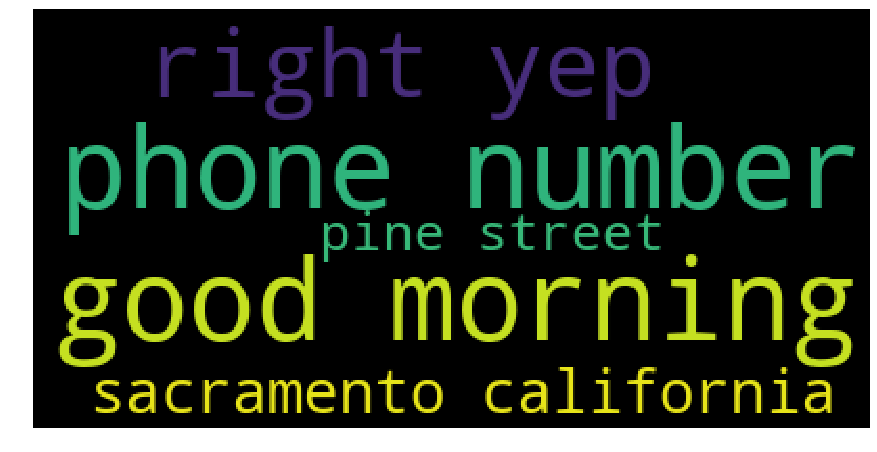

In [43]:
%matplotlib inline
maxWords = len(callcenterlogsKeywordsPandas)
nWords = 5

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
callcenterlogsKwdFreq = prepForWordCloud(callcenterlogsKeywordsPandas,nWords)
callcenterlogsWordCloud = WordCloud(max_words=maxWords,relative_scaling=0,normalize_plurals=False).generate_from_frequencies(callcenterlogsKwdFreq)

#plt.imshow(callcenterlogsWordCloud)

# If need to support multiple side-by-side word clouds, use commented lines below

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,15))
ax.imshow(callcenterlogsWordCloud)

## Set titles for images
#ax[0,0].set_title('Top Keywords from logs of call 1')
#ax[0,1].set_title('Overall Sentiment')
#ax[1,0].set_title('Top Keywords from logs of call 1')
#ax[1,1].set_title('Top Keywords from logs of call 2')

                
## Plot word clouds
#ax[0,0].imshow(callcenterlogsWordCloud)
#ax[0,1].pie(plot_values, labels = plot_labels, colors = plot_colors, autopct = '%1.1f%%')
#ax[1,0].imshow(callcenterlogsWordCloud)
#ax[1,1].imshow(callcenterlogsWordCloud)

# turn off axis and ticks
plt.axis("off")
#ax[0,0].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
#                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 
#ax[0,1].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
#                labelbottom='off',labeltop='off',labelleft='off',labelright='off') 
#ax[1,0].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
#                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 
#ax[1,1].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
#                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 


plt.show()

**Step 4: Visualize Emotion Tone using Watson Tone Analyzer response**

Define the function to parse Watson Tone Analyzer json response and extract emotion tone labels and scores.


Add code to visualize Emotion Tone (Refer to this notebook for some examples of how to do further visualization: https://github.com/mamoonraja/analyze-call-center-calls-with-watson/blob/master/notebooks/Step5-call-center-analytics.ipynb)